# Repair Results: Thesis Assets (Extracted from analyze_repair_results)


This notebook regenerates the **tables and figures referenced in the thesis** that originate from the repair-results analysis (see `temp/results/analyze_repair_results.ipynb`).


## Generated assets


- `tables/latex_table_time_efficiency.tex`


- `tables/latex_table_statistical_tests.tex`


- `tables/latex_table_realworld_accuracy.tex`


- `diagram/figure_repair_duration_distribution.pdf`


- `diagram/figure_stopping_conditions.pdf`


- `diagram/figure_generations_completed.pdf`


- `diagram/figure_model_comparison.pdf`


The notebook reads aggregated CSV files from `raw_data/` (produced earlier from the raw experiment logs) and surrogate model outputs from the thesis `temp/results/surrogate-model/` directory.
It also writes a copy of each generated asset to `data/` for convenience and auditing.

In [19]:
# Common imports and configuration
import shutil
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

EXPORT_TO_THESIS = True  # set to True to also copy outputs into tables/, diagram/

# Hard-coded thesis root (assumes this notebook is run from temp/results_analysis_thesis/)
THESIS_ROOT = Path('/Users/stefan/Workspace/bauers-ma/thesis/').resolve()

TABLES_DIR = THESIS_ROOT / 'tables'
DIAGRAM_DIR = THESIS_ROOT / 'diagram'

# Input/output directories relative to this notebook folder
BASE_PATH = Path('.') / 'data'
BASE_PATH_RAW_DATA = Path('.') / 'raw_data'
BASE_PATH.mkdir(exist_ok=True)

# Configuration order and colors (consistent across figures)
CONFIG_ORDER = ['FI-00', 'FI-50', 'FI-70', 'TO-50', 'TO-70']
CONFIG_COLORS = {
    'FI-00': '#7f8c8d',  # Gray - Baseline
    'FI-50': '#5dade2',  # Light Blue - Fitness 50%
    'FI-70': '#2471a3',  # Dark Blue - Fitness 70%
    'TO-50': '#f39c12',  # Light Orange - Test Outcome 50%
    'TO-70': '#d35400',  # Dark Orange - Test Outcome 70%
}

# Mapping from raw surrogate configuration IDs to human-readable labels
CONFIG_MAPPING = {
    'genProg-surrogate-model-fi-00': 'FI-00',
    'genProg-surrogate-model-fi-05': 'FI-50',
    'genProg-surrogate-model-fi-07': 'FI-70',
    'genProg-surrogate-model-to-05': 'TO-50',
    'genProg-surrogate-model-to-07': 'TO-70',
}

# Plotting style for publication-quality figures
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

# Load core aggregated CSVs
results_df = pd.read_csv(BASE_PATH_RAW_DATA / 'per_run_results.csv')
time_eff_df = pd.read_csv(BASE_PATH_RAW_DATA / 'time_efficiency_all_runs.csv')
stats_main_df = pd.read_csv(BASE_PATH_RAW_DATA / 'statistical_tests.csv')
stats_add_df = pd.read_csv(BASE_PATH_RAW_DATA / 'statistical_tests_additional.csv')

print('Loaded data sets:')
print(f'  per_run_results: {len(results_df)} rows')
print(f'  time_efficiency_all_runs: {len(time_eff_df)} rows')
print(f'  statistical_tests: {len(stats_main_df)} rows')
print(f'  statistical_tests_additional: {len(stats_add_df)} rows')
print(f'Thesis root: {THESIS_ROOT}')

Loaded data sets:
  per_run_results: 410 rows
  time_efficiency_all_runs: 5 rows
  statistical_tests: 8 rows
  statistical_tests_additional: 8 rows
Thesis root: /Users/stefan/Workspace/bauers-ma/thesis


## Time Efficiency Table (`latex_table_time_efficiency.tex`)

In [20]:
# Prepare time efficiency data (seconds -> minutes)
time_eff = time_eff_df.copy()
time_eff['mean_time_min'] = (time_eff['mean_time_sec'] / 60).round(1)
time_eff['median_time_min'] = (time_eff['median_time_sec'] / 60).round(1)
time_eff['speedup_vs_baseline'] = time_eff['speedup_vs_baseline'].round(2)
time_eff['time_saved_pct'] = time_eff['time_saved_pct'].round(1)
time_eff = time_eff.set_index('config').loc[CONFIG_ORDER].reset_index()

# Build LaTeX table
lines = []
lines.append(r"\begin{table}")
lines.append(r"\centering")
lines.append(r"\caption{Time Efficiency Comparison Across Configurations}")
lines.append(r"\label{tab:time-efficiency}")
lines.append(r"\begin{tabular}{lcccc}")
lines.append(r"\toprule")
lines.append(r"\textbf{Config} & \textbf{Mean (min)} & \textbf{Median (min)} & \textbf{Speedup} & \textbf{Saved (\%)} \\")
lines.append(r"\midrule")

for _, row in time_eff.iterrows():
    cfg = row['config']
    mean_m = f"{row['mean_time_min']:.1f}"
    median_m = f"{row['median_time_min']:.1f}"
    # \times must be in math mode to avoid 'Missing $ inserted' in LaTeX
    speedup = f"${row['speedup_vs_baseline']:.2f}\\times$"
    if speedup.startswith('$1.00'):
        speedup = '$1.00\\times$'
    saved = f"{row['time_saved_pct']:.1f}"
    lines.append(fr"{cfg} & {mean_m} & {median_m} & {speedup} & {saved} \\")

lines.append(r"\bottomrule")
lines.append(r"\end{tabular}")
lines.append(r"\end{table}")

out_local = BASE_PATH / 'latex_table_time_efficiency.tex'
out_local.write_text("\n".join(lines))
print(f'Saved LaTeX table to: {out_local}')

if EXPORT_TO_THESIS:
    out_thesis = TABLES_DIR / out_local.name
    shutil.copy2(out_local, out_thesis)
    print(f'Copied to: {out_thesis}')

Saved LaTeX table to: data/latex_table_time_efficiency.tex
Copied to: /Users/stefan/Workspace/bauers-ma/thesis/tables/latex_table_time_efficiency.tex


## Repair Duration Distribution (`figure_repair_duration_distribution.*`)

/var/folders/ld/bgn55ct90rbfyh1dnn5gfq9m0000gn/T/ipykernel_76782/3017417922.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(box_data, positions=range(len(CONFIG_ORDER)), labels=CONFIG_ORDER,


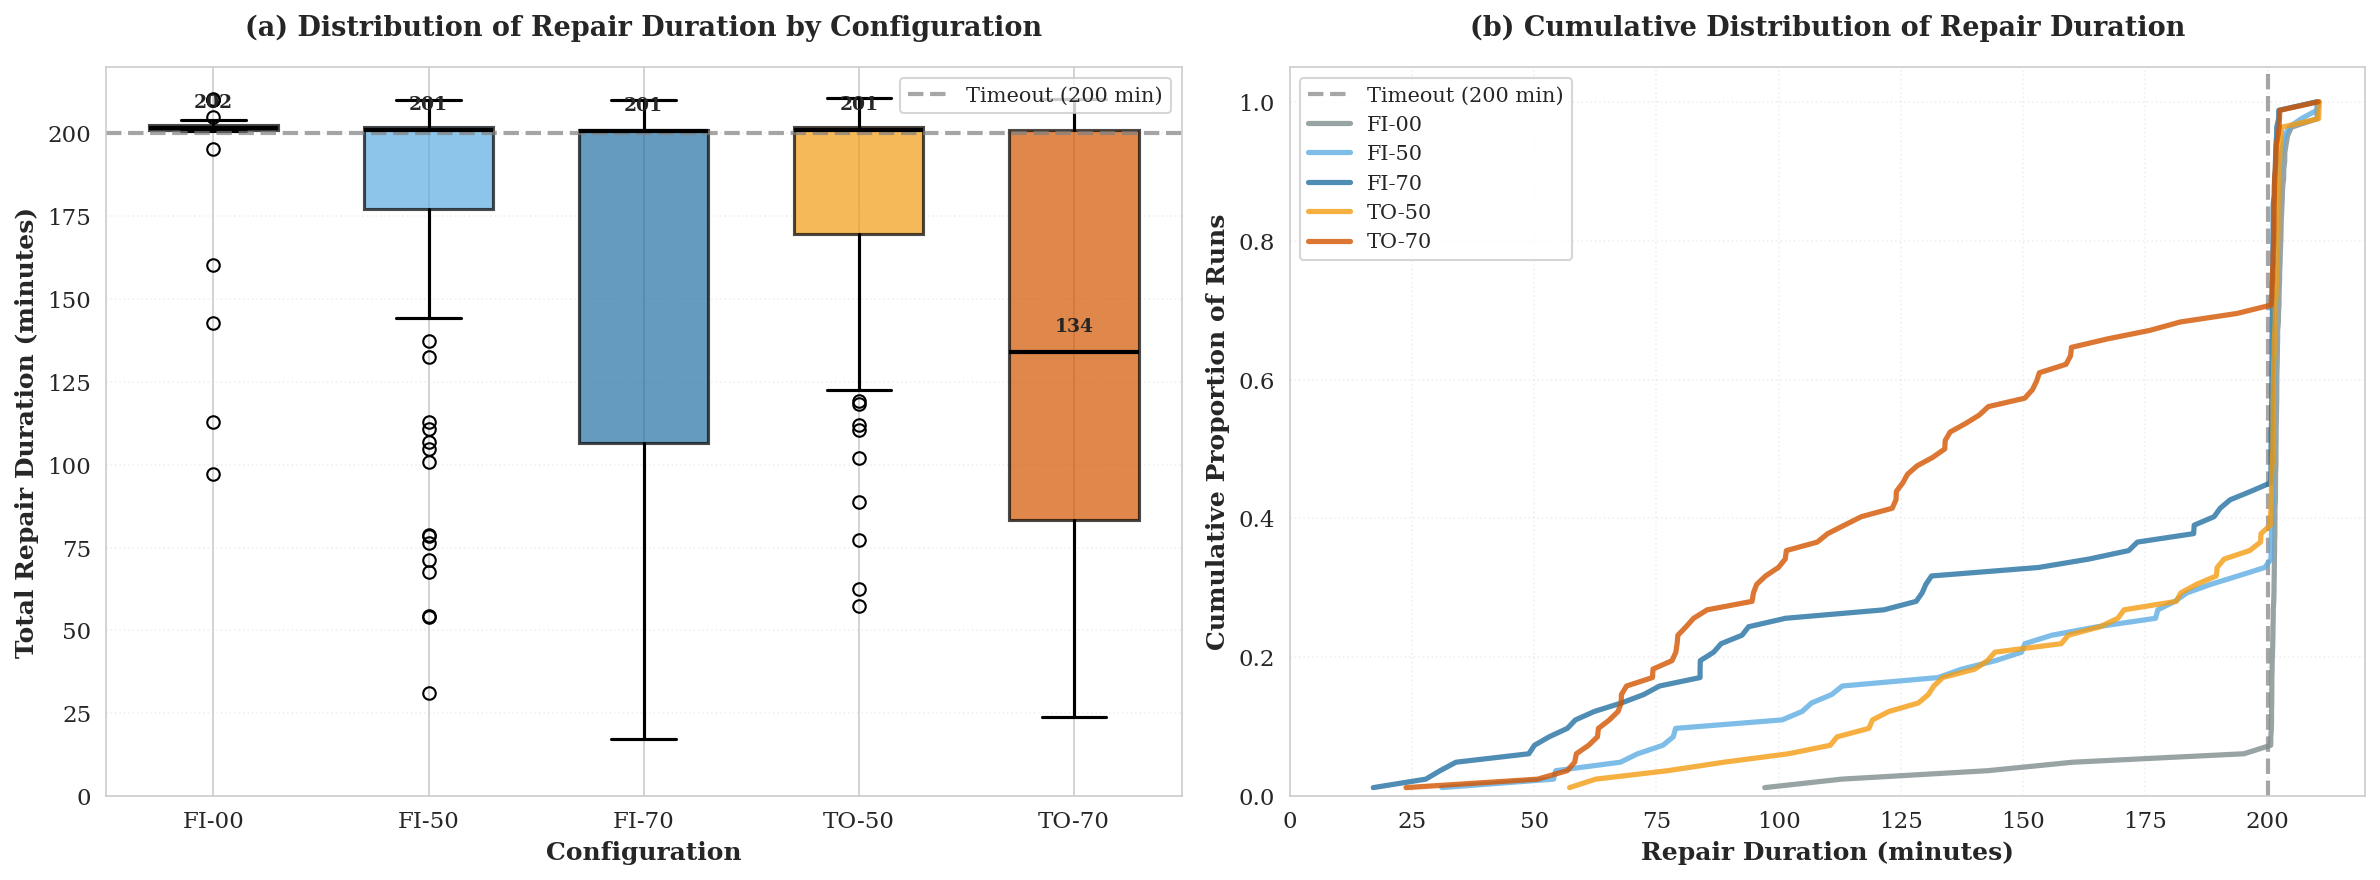

Figure saved as: data/figure_repair_duration_distribution.pdf / data/figure_repair_duration_distribution.png
Copied to: /Users/stefan/Workspace/bauers-ma/thesis/diagram/figure_repair_duration_distribution.pdf


In [21]:
# Prepare duration data (seconds -> minutes)
duration_data = results_df[results_df['duration_seconds'].notna()].copy()
duration_data['duration_minutes'] = duration_data['duration_seconds'] / 60.0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1) Box plot by configuration
box_data = [duration_data[duration_data['config'] == cfg]['duration_minutes'].values for cfg in CONFIG_ORDER]
bp = ax1.boxplot(box_data, positions=range(len(CONFIG_ORDER)), labels=CONFIG_ORDER,
               patch_artist=True, widths=0.6,
               medianprops=dict(color='black', linewidth=2),
               boxprops=dict(linewidth=1.5),
               whiskerprops=dict(linewidth=1.5),
               capprops=dict(linewidth=1.5))
for patch, cfg in zip(bp['boxes'], CONFIG_ORDER):
    patch.set_facecolor(CONFIG_COLORS[cfg])
    patch.set_alpha(0.7)

# Timeout reference line (200 minutes)
ax1.axhline(y=200, color='gray', linestyle='--', linewidth=2, alpha=0.7, label='Timeout (200 min)')
ax1.set_ylabel('Total Repair Duration (minutes)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Configuration', fontsize=12, fontweight='bold')
ax1.set_title('(a) Distribution of Repair Duration by Configuration', fontsize=13, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3, linestyle=':')
ax1.legend(loc='upper right', fontsize=10)
ax1.set_ylim(0, 220)

# Annotate medians
for i, cfg in enumerate(CONFIG_ORDER):
    median_val = duration_data[duration_data['config'] == cfg]['duration_minutes'].median()
    ax1.text(i, median_val + 5, f'{median_val:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2) Cumulative distribution function (CDF)
ax2.axvline(x=200, color='gray', linestyle='--', linewidth=2, alpha=0.7, label='Timeout (200 min)')
for cfg in CONFIG_ORDER:
    cfg_durations = duration_data[duration_data['config'] == cfg]['duration_minutes'].sort_values()
    if len(cfg_durations) == 0:
        continue
    cdf = np.arange(1, len(cfg_durations) + 1) / len(cfg_durations)
    ax2.plot(cfg_durations, cdf, linewidth=2.5, label=cfg, color=CONFIG_COLORS[cfg], alpha=0.8)

ax2.set_xlabel('Repair Duration (minutes)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative Proportion of Runs', fontsize=12, fontweight='bold')
ax2.set_title('(b) Cumulative Distribution of Repair Duration', fontsize=13, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, linestyle=':')
ax2.legend(loc='upper left', fontsize=10)
ax2.set_xlim(0, 220)
ax2.set_ylim(0, 1.05)

plt.tight_layout()
out_local_pdf = BASE_PATH / 'figure_repair_duration_distribution.pdf'
out_local_png = BASE_PATH / 'figure_repair_duration_distribution.png'
plt.savefig(out_local_pdf, dpi=300, bbox_inches='tight')
plt.savefig(out_local_png, dpi=300, bbox_inches='tight')
plt.show()
print(f'Figure saved as: {out_local_pdf} / {out_local_png}')

if EXPORT_TO_THESIS:
    out_thesis_pdf = DIAGRAM_DIR / out_local_pdf.name
    shutil.copy2(out_local_pdf, out_thesis_pdf)
    print(f'Copied to: {out_thesis_pdf}')

## Stopping Condition Distribution (`figure_stopping_conditions.*`)

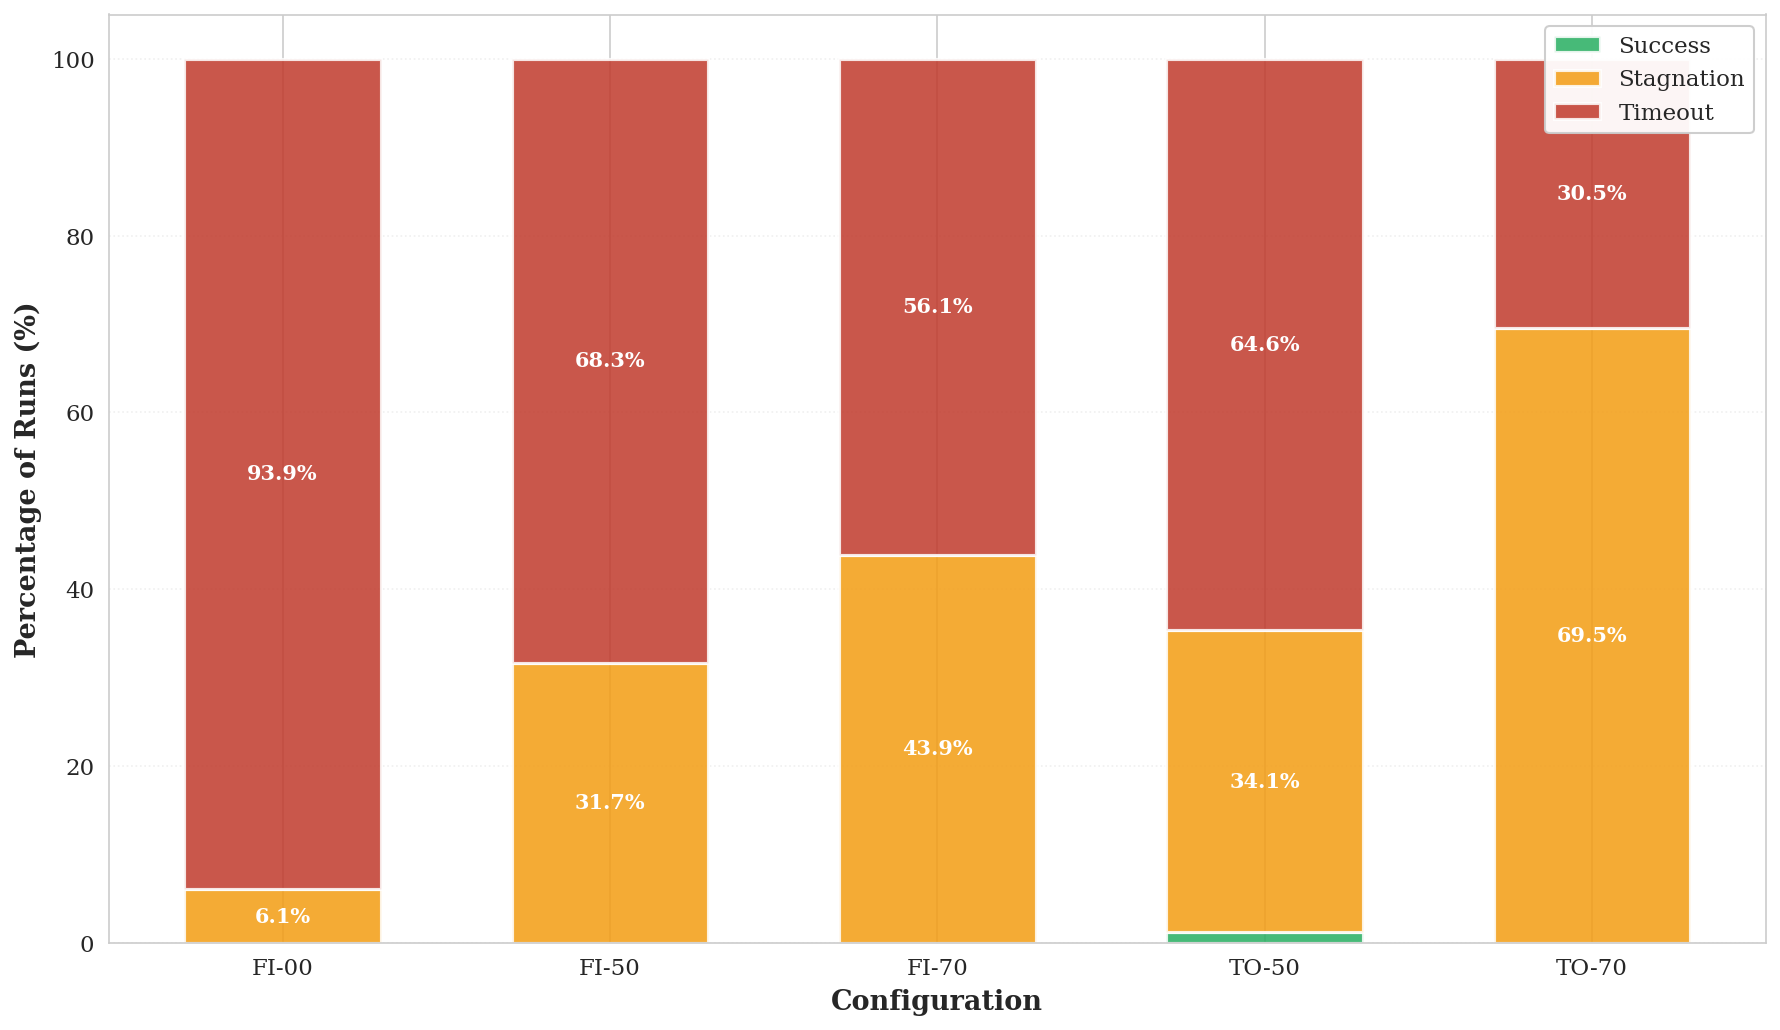

Figure saved as: data/figure_stopping_conditions.pdf / data/figure_stopping_conditions.png
Copied to: /Users/stefan/Workspace/bauers-ma/thesis/diagram/figure_stopping_conditions.pdf


In [22]:
timeout_threshold = 12000  # 200 minutes in seconds
records = []
for _, row in results_df.iterrows():
    if row['is_success']:
        condition = 'Success'
    elif pd.notna(row['duration_seconds']) and row['duration_seconds'] >= timeout_threshold - 100:
        condition = 'Timeout'
    else:
        condition = 'Stagnation'
    records.append({'config': row['config'], 'condition': condition})
stopping_df = pd.DataFrame(records)

summary = stopping_df.groupby(['config', 'condition']).size().reset_index(name='count')
totals = stopping_df.groupby('config').size().reset_index(name='total')
summary = summary.merge(totals, on='config')
summary['percentage'] = (summary['count'] / summary['total']) * 100

pivot = summary.pivot(index='config', columns='condition', values='percentage').fillna(0)
pivot = pivot.reindex(CONFIG_ORDER)
for col in ['Success', 'Stagnation', 'Timeout']:
    if col not in pivot.columns:
        pivot[col] = 0.0
pivot = pivot[['Success', 'Stagnation', 'Timeout']]

fig, ax = plt.subplots(figsize=(12, 7))
condition_colors = {'Success': '#27ae60', 'Stagnation': '#f39c12', 'Timeout': '#c0392b'}
x_pos = np.arange(len(CONFIG_ORDER))
bar_width = 0.6
bottom = np.zeros(len(CONFIG_ORDER))
for condition in ['Success', 'Stagnation', 'Timeout']:
    values = pivot[condition].values
    bars = ax.bar(x_pos, values, bar_width, bottom=bottom, label=condition,
                   color=condition_colors[condition], edgecolor='white', linewidth=1.5, alpha=0.85)
    for i, (bar, val) in enumerate(zip(bars, values)):
        if val >= 5:
            ax.text(bar.get_x() + bar.get_width()/2., bottom[i] + val/2, f'{val:.1f}%',
                    ha='center', va='center', fontweight='bold', fontsize=10, color='white')
    bottom += values

ax.set_ylabel('Percentage of Runs (%)', fontsize=13, fontweight='bold')
ax.set_xlabel('Configuration', fontsize=13, fontweight='bold')
#ax.set_title('Distribution of Stopping Conditions by Configuration', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(CONFIG_ORDER, fontsize=11)
ax.set_ylim(0, 105)
ax.legend(loc='upper right', fontsize=11, framealpha=0.95)
ax.grid(axis='y', alpha=0.3, linestyle=':')

plt.tight_layout()
out_local_pdf = BASE_PATH / 'figure_stopping_conditions.pdf'
out_local_png = BASE_PATH / 'figure_stopping_conditions.png'
plt.savefig(out_local_pdf, dpi=300, bbox_inches='tight')
plt.savefig(out_local_png, dpi=300, bbox_inches='tight')
plt.show()
print(f'Figure saved as: {out_local_pdf} / {out_local_png}')

if EXPORT_TO_THESIS:
    out_thesis_pdf = DIAGRAM_DIR / out_local_pdf.name
    shutil.copy2(out_local_pdf, out_thesis_pdf)
    print(f'Copied to: {out_thesis_pdf}')

## Generations Completed (`figure_generations_completed.*`)

          mean  median
config                
FI-00    98.12    84.5
FI-50   201.37   158.5
FI-70   279.06   224.5
TO-50   160.33   145.5
TO-70   187.37   180.5


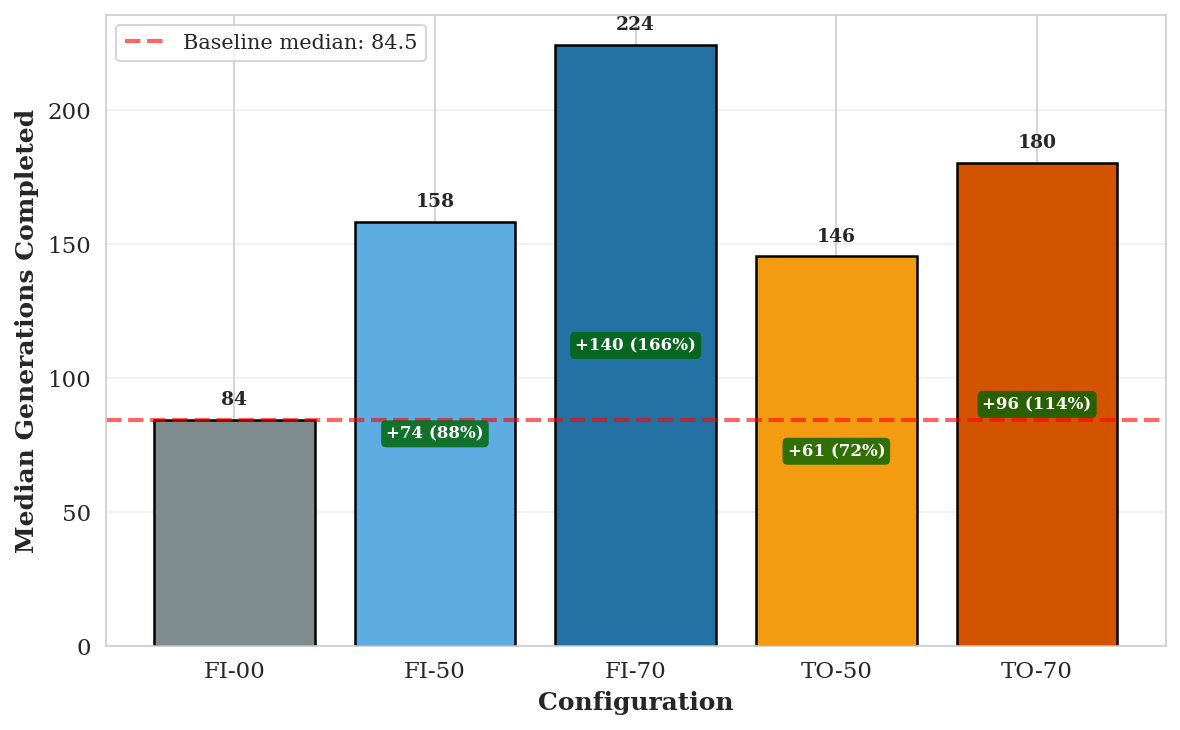

Figure saved as: data/figure_generations_completed.pdf / data/figure_generations_completed.png
Copied to: /Users/stefan/Workspace/bauers-ma/thesis/diagram/figure_generations_completed.pdf


In [23]:
gen_stats = results_df.groupby('config')['final_iteration'].agg(['mean', 'median']).reindex(CONFIG_ORDER)
print(gen_stats.round(2))

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(range(len(CONFIG_ORDER)), gen_stats['median'], color=[CONFIG_COLORS[c] for c in CONFIG_ORDER],
       edgecolor='black', linewidth=1.2)

baseline_median = gen_stats.loc['FI-00', 'median']
ax.axhline(baseline_median, color='red', linestyle='--', linewidth=2, alpha=0.6,
           label=f'Baseline median: {baseline_median:.1f}')

ax.set_xlabel('Configuration', fontsize=12, fontweight='bold')
ax.set_ylabel('Median Generations Completed', fontsize=12, fontweight='bold')
#ax.set_title('Generations Completed by Configuration', fontsize=13, fontweight='bold', pad=15)
ax.set_xticks(range(len(CONFIG_ORDER)))
ax.set_xticklabels(CONFIG_ORDER, fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.legend(loc='upper left', fontsize=10)

for i, cfg in enumerate(CONFIG_ORDER):
    median_val = gen_stats.loc[cfg, 'median']
    ax.text(i, median_val + 4, f'{median_val:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    if cfg != 'FI-00':
        increase = median_val - baseline_median
        pct = (increase / baseline_median) * 100 if baseline_median > 0 else 0.0
        ax.text(i, median_val * 0.5, f'+{increase:.0f} ({pct:.0f}%)', ha='center', va='center',
                fontsize=8, color='white', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='darkgreen', edgecolor='none', alpha=0.8))

plt.tight_layout()
out_local_pdf = BASE_PATH / 'figure_generations_completed.pdf'
out_local_png = BASE_PATH / 'figure_generations_completed.png'
plt.savefig(out_local_pdf, bbox_inches='tight')
plt.savefig(out_local_png, bbox_inches='tight', dpi=300)
plt.show()
print(f'Figure saved as: {out_local_pdf} / {out_local_png}')

if EXPORT_TO_THESIS:
    out_thesis_pdf = DIAGRAM_DIR / out_local_pdf.name
    shutil.copy2(out_local_pdf, out_thesis_pdf)
    print(f'Copied to: {out_thesis_pdf}')

## Statistical Tests Table (`latex_table_statistical_tests.tex`)

In [24]:
def format_p(p: float) -> str:
    if pd.isna(p):
        return ''
    if p < 0.001:
        return '$< 0.001$'
    return f'${p:.3f}$'

def format_d(d: float) -> str:
    if pd.isna(d):
        return ''
    return f'${d:.2f}$'

main_baseline = stats_main_df[stats_main_df['comparison'].str.startswith('Baseline vs')]
add_baseline = stats_add_df[stats_add_df['comparison'].str.startswith('Baseline vs')]

main_baseline = main_baseline.rename(columns={'config2': 'config'})
add_baseline = add_baseline.rename(columns={'config2': 'config'})
merged = pd.merge(main_baseline, add_baseline, on=['comparison', 'config', 'config1'], suffixes=('_main', '_add'))
merged = merged.set_index('config').loc[['FI-50', 'FI-70', 'TO-50', 'TO-70']]

lines = []
lines.append(r"\begin{table}")
lines.append(r"\centering")
lines.append(r"\caption{Statistical Significance Tests for All Metrics (vs FI-00 Baseline)}")
lines.append(r"\label{tab:statistical-tests}")
lines.append(r"\begin{tabular}{llcc}")
lines.append(r"\toprule")
# Optional commented header line (kept to match reference table)
lines.append(r"%\textbf{Metric}           & \textbf{Config} & \textbf{p-value} & \textbf{Effect Size} \\")
lines.append(r"\textbf{Metric}           & \textbf{Config} & \textbf{p-value} & \textbf{Effect Size} \\")
lines.append(r"\midrule")

def add_metric_row(metric_name, cfg, p_col, d_col):
    p = merged.loc[cfg, p_col]
    d = merged.loc[cfg, d_col]
    lines.append(fr"{metric_name} & {cfg} & {format_p(p)} & {format_d(d)} \\")

for cfg in ['FI-50', 'FI-70', 'TO-50', 'TO-70']:
    add_metric_row('Time to Repair', cfg, 'p_value_time', 'effect_size_time')
    add_metric_row('Test Executions', cfg, 'p_value_executions', 'effect_size_executions')
    add_metric_row('Time to First Improvement', cfg, 'p_value_time_first_improvement', 'effect_size_time_first_improvement')
    add_metric_row('Generations Completed', cfg, 'p_value_generations', 'effect_size_generations')
    if cfg != 'TO-70':
        lines.append(r"\midrule")

lines.append(r"\bottomrule")
lines.append(r"\end{tabular}")

# Simple note below the table (no minipage)
lines.append(r"\par\smallskip")
lines.append(r"{\footnotesize\textit{Note.} Significance level $\alpha = 0.05$. Effect sizes are Cohen's $d$.}\par")

lines.append(r"\end{table}")

out_local = BASE_PATH / 'latex_table_statistical_tests.tex'
out_local.write_text("\n".join(lines))
print(f'Saved LaTeX table to: {out_local}')

if EXPORT_TO_THESIS:
    out_thesis = TABLES_DIR / out_local.name
    shutil.copy2(out_local, out_thesis)
    print(f'Copied to: {out_thesis}')

Saved LaTeX table to: data/latex_table_statistical_tests.tex
Copied to: /Users/stefan/Workspace/bauers-ma/thesis/tables/latex_table_statistical_tests.tex


## Surrogate Model Comparison (`figure_model_comparison.*`)


This section recreates the **FI vs TO surrogate model comparison** figure used in the thesis.
It analyzes chromosomes that were both predicted by the surrogate models and later evaluated with actual test execution,
and generates `figure_model_comparison.pdf/png` showing (a) error distributions and (b) MAE/RMSE for the two models.

In [25]:
# Build surrogate-model comparison data (FI vs TO)
import os

# Paths to surrogate-model runs (copied from the original thesis temp/results folder)
RESULTS_DIR = (Path('..') / 'temp_results').resolve()
SURROGATE_PATH = RESULTS_DIR / 'surrogate-model'

if not SURROGATE_PATH.exists():
    raise FileNotFoundError(f'Surrogate-model folder not found: {SURROGATE_PATH}')

tasks_csv = SURROGATE_PATH / 'tasks.csv'
if not tasks_csv.exists():
    raise FileNotFoundError(f'Tasks CSV not found: {tasks_csv}')

surrogate_tasks = pd.read_csv(tasks_csv)
job_to_config = dict(zip(surrogate_tasks['job_id'], surrogate_tasks['config']))

print(f'Surrogate model tasks loaded: {len(surrogate_tasks)} rows')
print('Configuration distribution (raw IDs):')
print(surrogate_tasks['config'].value_counts())

surrogate_dirs = [d for d in os.listdir(SURROGATE_PATH) if (SURROGATE_PATH / d).is_dir() and d.isdigit()]
print(f"\nFound {len(surrogate_dirs)} surrogate model run directories")
print('Loading runs and matching predicted vs evaluated chromosomes...')

all_comparisons = []

for run_dir in sorted(surrogate_dirs, key=int):
    run_path = SURROGATE_PATH / run_dir / 'output.csv'
    if not run_path.exists():
        continue

    run_id = int(run_dir)
    raw_config = job_to_config.get(run_id, 'unknown')
    mapped_config = CONFIG_MAPPING.get(raw_config, raw_config)
    # Derive model type directly from mapped config label
    if mapped_config.startswith('FI-'):
        model_type = 'fitness'
    elif mapped_config.startswith('TO-'):
        model_type = 'testoutcome'
    else:
        model_type = 'unknown'

    run_df = pd.read_csv(run_path, low_memory=False)

    predicted = run_df[run_df['fitnessEvalType'] == 'fitnessPrediction'].copy()
    evaluated = run_df[run_df['fitnessEvalType'] == 'fitnessEvaluation'].copy()

    common_hashes = set(predicted['hashCode']) & set(evaluated['hashCode'])

    for hash_code in common_hashes:
        pred_rows = predicted[predicted['hashCode'] == hash_code]
        eval_rows = evaluated[evaluated['hashCode'] == hash_code]
        if len(pred_rows) == 0 or len(eval_rows) == 0:
            continue
        pred_row = pred_rows.iloc[0]
        eval_row = eval_rows.iloc[0]
        all_comparisons.append({
            'run_id': run_dir,
            'config': mapped_config,
            'model_type': model_type,
            'hashCode': hash_code,
            'predicted_fitness': pred_row['fitness'],
            'actual_fitness': eval_row['fitness'],
            'pred_iteration': pred_row['iteration'],
            'eval_iteration': eval_row['iteration']
        })

comparisons_df = pd.DataFrame(all_comparisons)
print(f"\nFound {len(comparisons_df)} chromosomes with both predictions and evaluations")
print(f"From {len(comparisons_df['run_id'].unique())} different runs")

comparisons_df['fitness_error'] = comparisons_df['predicted_fitness'] - comparisons_df['actual_fitness']
comparisons_df['fitness_abs_error'] = comparisons_df['fitness_error'].abs()
comparisons_df['fitness_squared_error'] = comparisons_df['fitness_error'] ** 2

comparisons_df['fitness_pct_error'] = np.where(
    comparisons_df['actual_fitness'].abs() > 0,
    (comparisons_df['fitness_abs_error'] / comparisons_df['actual_fitness'].abs()) * 100,
    0
)

fi_data = comparisons_df[comparisons_df['model_type'] == 'fitness']
to_data = comparisons_df[comparisons_df['model_type'] == 'testoutcome']

print('\nData prepared for surrogate-model visualization:')
print(f'  FI model chromosomes: {len(fi_data):,}')
print(f'  TO model chromosomes: {len(to_data):,}')

Surrogate model tasks loaded: 328 rows
Configuration distribution (raw IDs):
config
genProg-surrogate-model-fi-05    82
genProg-surrogate-model-fi-07    82
genProg-surrogate-model-to-05    82
genProg-surrogate-model-to-07    82
Name: count, dtype: int64

Found 328 surrogate model run directories
Loading runs and matching predicted vs evaluated chromosomes...

Found 285119 chromosomes with both predictions and evaluations
From 328 different runs

Data prepared for surrogate-model visualization:
  FI model chromosomes: 148,940
  TO model chromosomes: 136,179


In [26]:
# Table: Real-World Fitness Prediction Accuracy (latex_table_realworld_accuracy.tex)

# Overall, FI, and TO model metrics on chromosomes evaluated during repair
print("="*80)
print("TABLE: Real-World Fitness Prediction Accuracy During Repair")
print("="*80)

table1 = r"""\begin{table}
\centering
\caption{Real-World Fitness Prediction Accuracy During Repair}
\label{tab:prediction_accuracy_realworld}
\begin{tabular}{lrrr}
\toprule
\textbf{Metric} & \textbf{Overall} & \textbf{FI Model} & \textbf{TO Model} \\
\midrule
Chromosomes Analyzed & """ + f"{len(comparisons_df):,}" + r""" & """ + f"{len(fi_data):,}" + r""" & """ + f"{len(to_data):,}" + r""" \\
\midrule
\multicolumn{4}{l}{\textbf{Fitness Prediction Accuracy}} \\
"""

table1 += f"Mean Absolute Error (MAE) & {comparisons_df['fitness_abs_error'].mean():.2f} & {fi_data['fitness_abs_error'].mean():.2f} & {to_data['fitness_abs_error'].mean():.2f} \\\\\n"
table1 += f"Root Mean Squared Error (RMSE) & {np.sqrt(comparisons_df['fitness_squared_error'].mean()):.2f} & {np.sqrt(fi_data['fitness_squared_error'].mean()):.2f} & {np.sqrt(to_data['fitness_squared_error'].mean()):.2f} \\\\\n"
table1 += f"Median Absolute Error & {comparisons_df['fitness_abs_error'].median():.2f} & {fi_data['fitness_abs_error'].median():.2f} & {to_data['fitness_abs_error'].median():.2f} \\\\\n"
table1 += f"Mean Percentage Error & {comparisons_df['fitness_pct_error'].mean():.1f}\\% & {fi_data['fitness_pct_error'].mean():.1f}\\% & {to_data['fitness_pct_error'].mean():.1f}\\% \\\\\n"
table1 += f"Median Percentage Error & {comparisons_df['fitness_pct_error'].median():.1f}\\% & {fi_data['fitness_pct_error'].median():.1f}\\% & {to_data['fitness_pct_error'].median():.1f}\\% \\\\\n"
table1 += f"Standard Deviation & {comparisons_df['fitness_abs_error'].std():.2f} & {fi_data['fitness_abs_error'].std():.2f} & {to_data['fitness_abs_error'].std():.2f} \\\\\n"

table1 += r"""\bottomrule
\end{tabular}
\end{table}
"""

out_local = BASE_PATH / 'latex_table_realworld_accuracy.tex'
out_local.write_text(table1)

print(table1)
print(f"Saved: {out_local.name}")
print("  USAGE: Include in Experiments & Results chapter (Real-World Validation section)")
print("  NOTE: Validates models on actual repair data during genetic programming runs")
print(f"\nKEY FINDING: FI model has {(to_data['fitness_abs_error'].mean() - fi_data['fitness_abs_error'].mean()) / fi_data['fitness_abs_error'].mean() * 100:.1f}% lower MAE than TO model\n")

if EXPORT_TO_THESIS:
    TABLES_DIR.mkdir(parents=True, exist_ok=True)
    out_thesis = TABLES_DIR / out_local.name
    shutil.copy2(out_local, out_thesis)
    print(f'Copied to thesis tables/: {out_thesis}')

TABLE: Real-World Fitness Prediction Accuracy During Repair
\begin{table}
\centering
\caption{Real-World Fitness Prediction Accuracy During Repair}
\label{tab:prediction_accuracy_realworld}
\begin{tabular}{lrrr}
\toprule
\textbf{Metric} & \textbf{Overall} & \textbf{FI Model} & \textbf{TO Model} \\
\midrule
Chromosomes Analyzed & 285,119 & 148,940 & 136,179 \\
\midrule
\multicolumn{4}{l}{\textbf{Fitness Prediction Accuracy}} \\
Mean Absolute Error (MAE) & 6.48 & 5.76 & 7.27 \\
Root Mean Squared Error (RMSE) & 7.67 & 6.74 & 8.58 \\
Median Absolute Error & 6.39 & 5.97 & 6.87 \\
Mean Percentage Error & 41.8\% & 43.2\% & 40.3\% \\
Median Percentage Error & 36.4\% & 37.8\% & 35.3\% \\
Standard Deviation & 4.10 & 3.49 & 4.55 \\
\bottomrule
\end{tabular}
\end{table}

Saved: latex_table_realworld_accuracy.tex
  USAGE: Include in Experiments & Results chapter (Real-World Validation section)
  NOTE: Validates models on actual repair data during genetic programming runs

KEY FINDING: FI model has 

/var/folders/ld/bgn55ct90rbfyh1dnn5gfq9m0000gn/T/ipykernel_76782/1181556115.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=LABELS,


Figure saved as: data/figure_model_comparison.pdf / data/figure_model_comparison.png
Copied to thesis: /Users/stefan/Workspace/bauers-ma/thesis/diagram/figure_model_comparison.pdf
Copied to thesis: /Users/stefan/Workspace/bauers-ma/thesis/diagram/figure_model_comparison.png


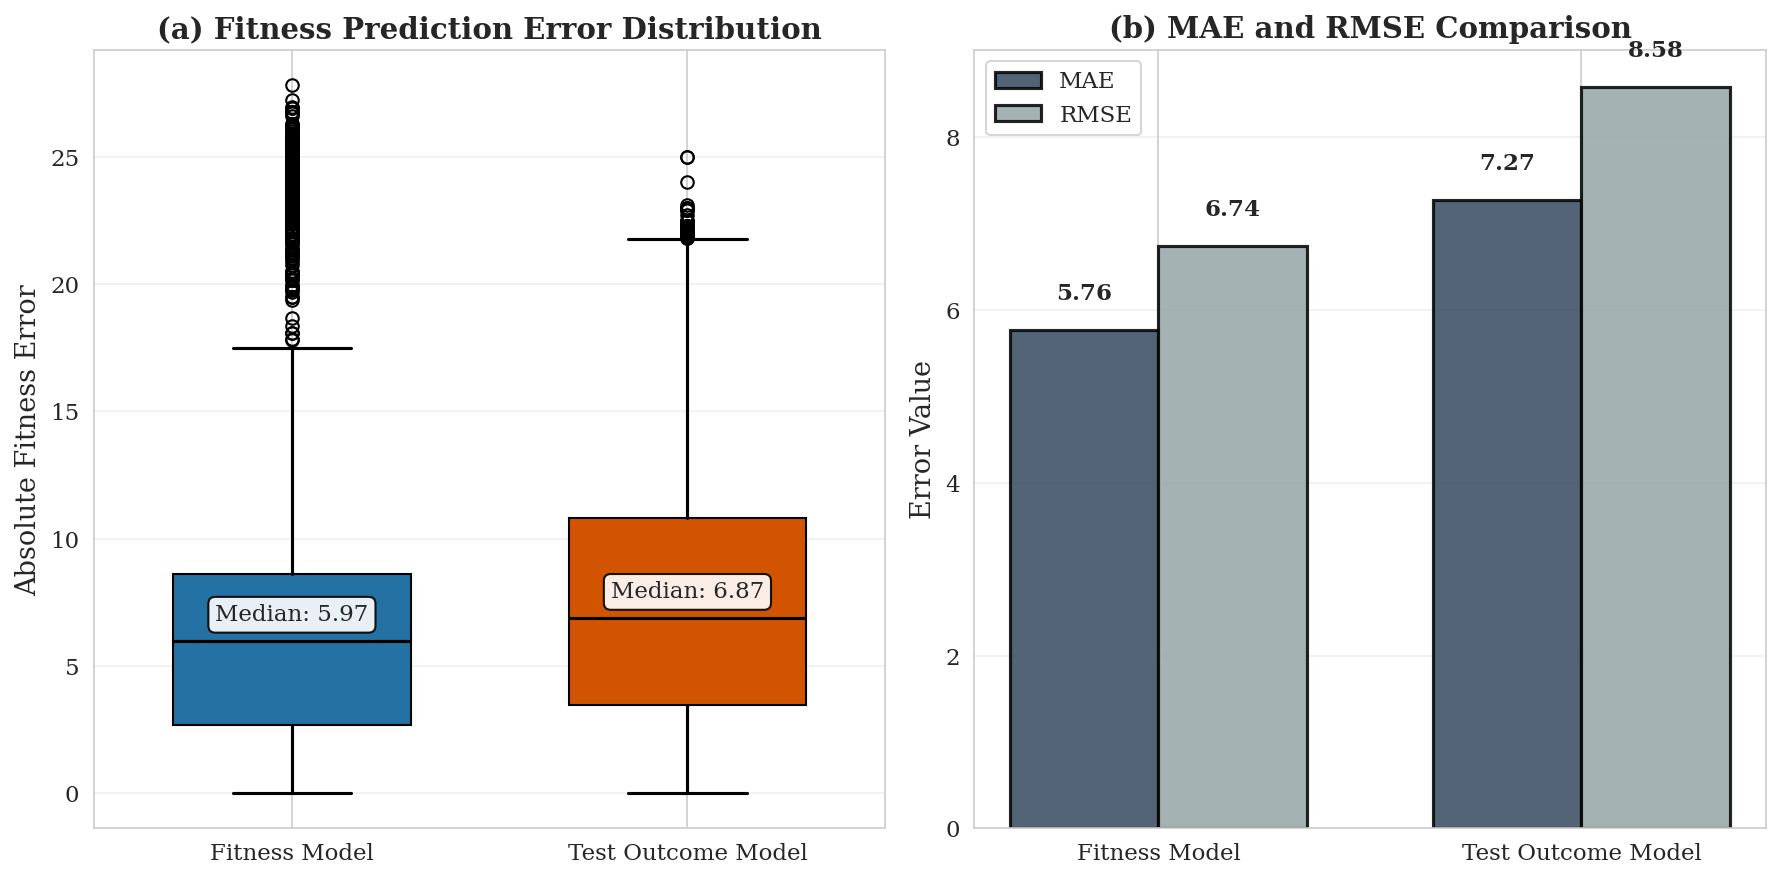

In [27]:
# Figure: Model Comparison Overview (Fitness Prediction Only)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')
fig.patch.set_facecolor('white')

# Define clean colors for publication
FI_COLOR = '#2471a3'  # Dark blue
TO_COLOR = '#d35400'  # Dark orange

LABELS = ['Fitness Model', 'Test Outcome Model']

# Left: Fitness Error Distribution (Box Plot)
ax = axes[0]
ax.set_facecolor('white')
data_to_plot = [fi_data['fitness_abs_error'], to_data['fitness_abs_error']]
bp = ax.boxplot(data_to_plot, labels=LABELS,
                patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor(FI_COLOR)
bp['boxes'][1].set_facecolor(TO_COLOR)
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='black', linewidth=1.5)
ax.set_ylabel('Absolute Fitness Error', fontsize=13)
ax.set_title('(a) Fitness Prediction Error Distribution', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.tick_params(axis='both', which='major', labelsize=11)

median_fi = fi_data['fitness_abs_error'].median()
median_to = to_data['fitness_abs_error'].median()
ax.text(1, median_fi + 0.8, f'Median: {median_fi:.2f}',
        ha='center', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))
ax.text(2, median_to + 0.8, f'Median: {median_to:.2f}',
        ha='center', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Right: MAE and RMSE Comparison
ax = axes[1]
ax.set_facecolor('white')
x = np.arange(2)
width = 0.35
fi_mae = fi_data['fitness_abs_error'].mean()
to_mae = to_data['fitness_abs_error'].mean()
fi_rmse = np.sqrt(fi_data['fitness_squared_error'].mean())
to_rmse = np.sqrt(to_data['fitness_squared_error'].mean())

MAE_COLOR = '#34495e'   # Dark gray-blue for MAE
RMSE_COLOR = '#95a5a6'  # Light gray for RMSE

bars1 = ax.bar(x - width/2, [fi_mae, to_mae], width,
               label='MAE', color=MAE_COLOR,
               alpha=0.85, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, [fi_rmse, to_rmse], width,
               label='RMSE', color=RMSE_COLOR,
               alpha=0.85, edgecolor='black', linewidth=1.5)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                f'{height:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Error Value', fontsize=13)
ax.set_title('(b) MAE and RMSE Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(LABELS, fontsize=11)
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
ax.tick_params(axis='both', which='major', labelsize=11)

plt.tight_layout()

# Save into local data/ folder (replication package canonical output)
out_pdf = BASE_PATH / 'figure_model_comparison.pdf'
out_png = BASE_PATH / 'figure_model_comparison.png'
plt.savefig(out_pdf, bbox_inches='tight', dpi=300, facecolor='white')
plt.savefig(out_png, bbox_inches='tight', dpi=300, facecolor='white')
print(f'Figure saved as: {out_pdf} / {out_png}')

# Optionally copy into thesis diagram/ folder
if EXPORT_TO_THESIS:
    DIAGRAM_DIR.mkdir(parents=True, exist_ok=True)
    thesis_pdf = DIAGRAM_DIR / out_pdf.name
    thesis_png = DIAGRAM_DIR / out_png.name
    thesis_pdf.write_bytes(out_pdf.read_bytes())
    thesis_png.write_bytes(out_png.read_bytes())
    print(f'Copied to thesis: {thesis_pdf}')
    print(f'Copied to thesis: {thesis_png}')
else:
    print('EXPORT_TO_THESIS is False – not copying into thesis diagram/.')

plt.show()

## Output check


This section lists the generated files in `data/` and (if enabled) verifies that the thesis folders contain the expected outputs.

In [28]:
generated_local = sorted([p.name for p in BASE_PATH.glob('latex_table_*.tex')]) + sorted([p.name for p in BASE_PATH.glob('figure_*.pdf')])
print('Generated in data/:')
for name in generated_local:
    print(f'  - {name}')

if EXPORT_TO_THESIS:
    expected_tables = ['latex_table_time_efficiency.tex', 'latex_table_statistical_tests.tex', 'latex_table_realworld_accuracy.tex']
    expected_figs = ['figure_repair_duration_distribution.pdf', 'figure_stopping_conditions.pdf', 'figure_generations_completed.pdf', 'figure_model_comparison.pdf']
    print('\nThesis tables present:')
    for name in expected_tables:
        print(f'  - {name}: {(TABLES_DIR / name).exists()}')
    print('\nThesis figures present:')
    for name in expected_figs:
        print(f'  - {name}: {(DIAGRAM_DIR / name).exists()}')

Generated in data/:
  - latex_table_realworld_accuracy.tex
  - latex_table_statistical_tests.tex
  - latex_table_time_efficiency.tex
  - figure_generations_completed.pdf
  - figure_model_comparison.pdf
  - figure_repair_duration_distribution.pdf
  - figure_stopping_conditions.pdf

Thesis tables present:
  - latex_table_time_efficiency.tex: True
  - latex_table_statistical_tests.tex: True
  - latex_table_realworld_accuracy.tex: True

Thesis figures present:
  - figure_repair_duration_distribution.pdf: True
  - figure_stopping_conditions.pdf: True
  - figure_generations_completed.pdf: True
  - figure_model_comparison.pdf: True
